# List datasets path

In [209]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python Docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

# Input data files are available in the read-only "../input/" directory
# For example, running this (by clicking run or pressing Shift+Enter) will list all files under the input directory

import os
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        print(os.path.join(dirname, filename))

# You can write up to 20GB to the current directory (/kaggle/working/) that gets preserved as output when you create a version using "Save & Run All" 
# You can also write temporary files to /kaggle/temp/, but they won't be saved outside of the current session

/kaggle/input/spaceship-titanic/sample_submission.csv
/kaggle/input/spaceship-titanic/train.csv
/kaggle/input/spaceship-titanic/test.csv


# Import required libraries

In [210]:
import matplotlib.pyplot as plt

from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.pipeline import make_pipeline

from sklearn.linear_model import LogisticRegression as LOG
from sklearn.ensemble import RandomForestClassifier as RF

from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, confusion_matrix, classification_report

# Import all datasets

In [211]:
train_df = pd.read_csv("/kaggle/input/spaceship-titanic/train.csv")
test_df = pd.read_csv("/kaggle/input/spaceship-titanic/test.csv")
submission_df = pd.read_csv("/kaggle/input/spaceship-titanic/sample_submission.csv")

train_df.head(10)

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name,Transported
0,0001_01,Europa,False,B/0/P,TRAPPIST-1e,39.0,False,0.0,0.0,0.0,0.0,0.0,Maham Ofracculy,False
1,0002_01,Earth,False,F/0/S,TRAPPIST-1e,24.0,False,109.0,9.0,25.0,549.0,44.0,Juanna Vines,True
2,0003_01,Europa,False,A/0/S,TRAPPIST-1e,58.0,True,43.0,3576.0,0.0,6715.0,49.0,Altark Susent,False
3,0003_02,Europa,False,A/0/S,TRAPPIST-1e,33.0,False,0.0,1283.0,371.0,3329.0,193.0,Solam Susent,False
4,0004_01,Earth,False,F/1/S,TRAPPIST-1e,16.0,False,303.0,70.0,151.0,565.0,2.0,Willy Santantines,True
5,0005_01,Earth,False,F/0/P,PSO J318.5-22,44.0,False,0.0,483.0,0.0,291.0,0.0,Sandie Hinetthews,True
6,0006_01,Earth,False,F/2/S,TRAPPIST-1e,26.0,False,42.0,1539.0,3.0,0.0,0.0,Billex Jacostaffey,True
7,0006_02,Earth,True,G/0/S,TRAPPIST-1e,28.0,False,0.0,0.0,0.0,0.0,NaN,Candra Jacostaffey,True
8,0007_01,Earth,False,F/3/S,TRAPPIST-1e,35.0,False,0.0,785.0,17.0,216.0,0.0,Andona Beston,True
9,0008_01,Europa,True,B/1/P,55 Cancri e,14.0,False,0.0,0.0,0.0,0.0,0.0,Erraiam Flatic,True


# Fullfill datasets nan error

In [212]:
print(f"train.csv nan error\n", train_df.isna().sum())
print("--------------------\n")
print(f"test.csv nan error\n", test_df.isna().sum())
print("--------------------\n")
print(f"sample_submission.csv nan error\n", submission_df.isna().sum())
print("--------------------\n")

train.csv nan error
 PassengerId       0
HomePlanet      201
CryoSleep       217
Cabin           199
Destination     182
Age             179
VIP             203
RoomService     181
FoodCourt       183
ShoppingMall    208
Spa             183
VRDeck          188
Name            200
Transported       0
dtype: int64
--------------------

test.csv nan error
 PassengerId       0
HomePlanet       87
CryoSleep        93
Cabin           100
Destination      92
Age              91
VIP              93
RoomService      82
FoodCourt       106
ShoppingMall     98
Spa             101
VRDeck           80
Name             94
dtype: int64
--------------------

sample_submission.csv nan error
 PassengerId    0
Transported    0
dtype: int64
--------------------



In [213]:
def convert_nan_errors(df):
    features_mean_type = {
        "HomePlanet": "mode",
        "CryoSleep": "mode",
        "Cabin": "mode",
        "Destination": "mode",
        "Age": "mean",
        "VIP": "mode",
        "RoomService": "mean",
        "FoodCourt": "mean",
        "ShoppingMall": "mean",
        "Spa": "mean",
        "VRDeck": "mean",
        "Name": ""
    }
    # loop through dataframe columns
    for col in df:
        # "Name" nan col
        if (col == "Name" and df[col].isna().sum() > 0):
            # loop through the dataframe rows
            for i in range(1, (len(df)-1)):
                # prev name
                prev_family_id, prev_person_id = df.loc[i-1, "PassengerId"].split("_")
                prev_name = df.loc[i-1, "Name"]
                # actual name
                actual_family_id, actual_person_id = df.loc[i, "PassengerId"].split("_")
                actual_name = df.loc[i, "Name"]
                # next name
                next_family_id, next_person_id = df.loc[i+1, "PassengerId"].split("_")
                next_name = df.loc[i+1, "Name"]
                # first row
                if (i == 1):
                    # if previous element name is nan
                    if (pd.isna(prev_name)):
                        # anonymous + family name
                        if (prev_family_id == actual_family_id and not pd.isna(actual_name)):
                            df.loc[i-1, 'Name'] = "X" + prev_person_id + " " + actual_name.split(" ")[1]
                        # anonymous name
                        else:
                            df.loc[i-1, 'Name'] = "X" + prev_person_id + " " + "Y" + str(np.random.randint(-2**31, 2**31))
                # last row
                if (i == (len(df)-2)):
                    # if previous element name is nan
                    if (pd.isna(next_name)):
                        # anonymous + family name
                        if (next_family_id == actual_family_id and not pd.isna(actual_name)):
                            df.loc[i+1, 'Name'] = "X" + next_person_id + " " + actual_name.split(" ")[1]
                        # anonymous name
                        else:
                            df.loc[i+1, 'Name'] = "X" + next_person_id + " " + "Y" + str(np.random.randint(-2**31, 2**31))
                # rows between the first and last ones
                if (pd.isna(actual_name)):
                    if (actual_family_id == prev_family_id):
                        df.loc[i, "Name"] = "X" + actual_person_id + " " + prev_name.split(" ")[1]
                    elif (actual_family_id == next_family_id):
                        if not pd.isna(next_name):
                            df.loc[i, "Name"] = "X" + actual_person_id + " " + next_name.split(" ")[1]
                        else:
                            df.loc[i, "Name"] = "X" + actual_person_id + " " + "Y" + str(np.random.randint(-2**31, 2**31))
                    else:
                        df.loc[i, "Name"] = "X" + actual_person_id + " " + "Y" + str(np.random.randint(2**-31, 2**31))
        # others nan cols
        elif (df[col].isna().sum() > 0):
            if features_mean_type[col] == "mean":
                df[col].fillna(df[col].mean(), inplace=True)
            elif features_mean_type[col] == "mode":
                df[col].fillna(df[col].mode()[0], inplace=True)
            else:
                continue
        # normal cols
        else: continue
                    
convert_nan_errors(train_df)
convert_nan_errors(test_df)

In [214]:
print(f"train.csv nan error\n", train_df.isna().sum())
print("--------------------\n")
print(f"test.csv nan error\n", test_df.isna().sum())
print("--------------------\n")
print(f"sample_submission.csv nan error\n", submission_df.isna().sum())
print("--------------------\n")

train.csv nan error
 PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
Transported     0
dtype: int64
--------------------

test.csv nan error
 PassengerId     0
HomePlanet      0
CryoSleep       0
Cabin           0
Destination     0
Age             0
VIP             0
RoomService     0
FoodCourt       0
ShoppingMall    0
Spa             0
VRDeck          0
Name            0
dtype: int64
--------------------

sample_submission.csv nan error
 PassengerId    0
Transported    0
dtype: int64
--------------------



# Analyse features with graphs

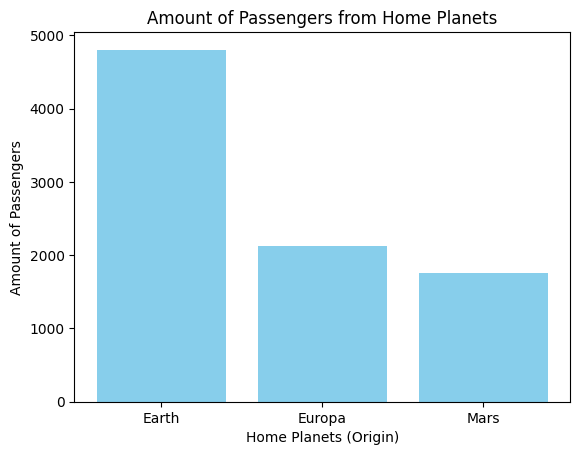

In [215]:
# amount of homeplanet passengers (origin)
fig, ax = plt.subplots()
home_planet_counts = train_df.groupby("HomePlanet")["PassengerId"].count()

ax.bar(home_planet_counts.index, home_planet_counts.values, color="skyblue")
ax.set_xlabel("Home Planets (Origin)")
ax.set_ylabel("Amount of Passengers")
ax.set_title("Amount of Passengers from Home Planets")

plt.show()

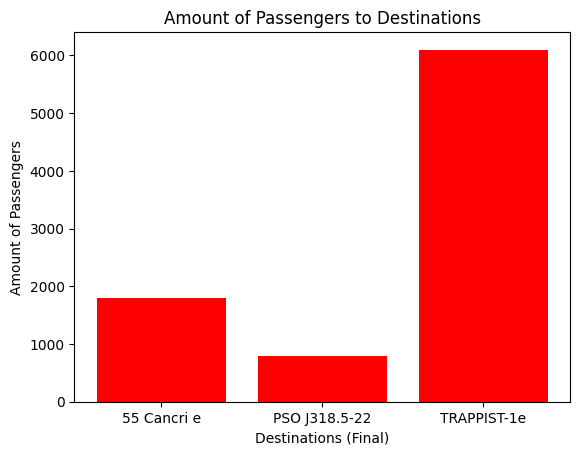

In [216]:
# amount of destinations passengers (final)
fig, ax = plt.subplots()
destinations_counts = train_df.groupby("Destination")["PassengerId"].count()

ax.bar(destinations_counts.index, destinations_counts.values, color="red")
ax.set_xlabel("Destinations (Final)")
ax.set_ylabel("Amount of Passengers")
ax.set_title("Amount of Passengers to Destinations")

plt.show()

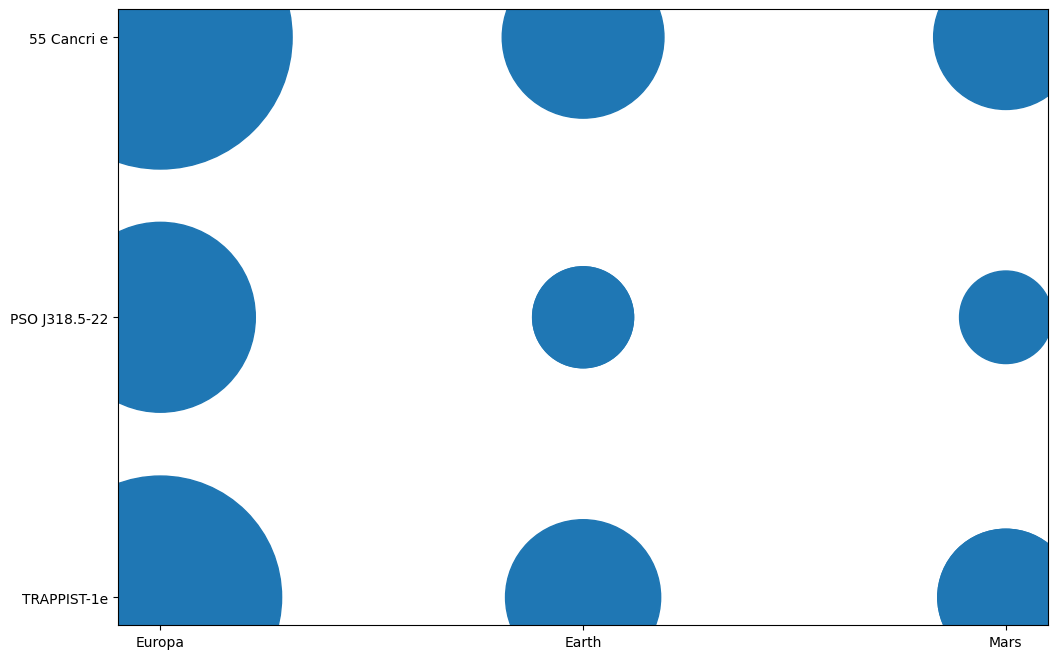

In [217]:
# passengers finance classes
fig, ax = plt.subplots(figsize=(12, 8))
all_spent = train_df["RoomService"] + train_df["FoodCourt"] + train_df["ShoppingMall"] + train_df["Spa"] + train_df["VRDeck"]

ax.scatter(train_df["HomePlanet"], train_df["Destination"], s=all_spent)
plt.show()

# Convert data

In [218]:
train_df.dtypes

PassengerId      object
HomePlanet       object
CryoSleep          bool
Cabin            object
Destination      object
Age             float64
VIP                bool
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name             object
Transported        bool
dtype: object

In [219]:
# label categorical data into numerical
def convertCategoricalData(df):
    for col in df.select_dtypes(["object", "bool"]).columns:
        le = LabelEncoder()
        df[col] = le.fit_transform(df[col])
    return df

train_df = convertCategoricalData(train_df)
test_df = convertCategoricalData(test_df)

train_df.dtypes

PassengerId       int64
HomePlanet        int64
CryoSleep         int64
Cabin             int64
Destination       int64
Age             float64
VIP               int64
RoomService     float64
FoodCourt       float64
ShoppingMall    float64
Spa             float64
VRDeck          float64
Name              int64
Transported       int64
dtype: object

# Train model

In [220]:
y = train_df.pop("Transported")
X = train_df

X

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,5252
1,1,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,4502
2,2,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,457
3,3,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,7149
4,4,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,8319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688,1,0,146,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,3524
8689,8689,0,1,5280,1,18.0,0,0.0,0.0,0.0,0.0,0.0,4780
8690,8690,0,0,5285,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,3002
8691,8691,1,0,2131,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,1596


In [221]:
# split data
X_train, X_val, y_train, y_val = train_test_split(X, y, test_size=0.2, random_state=42)

X_train

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
2333,2333,0,0,6156,2,28.0,0,0.000000,55.0,0.0,656.0,0.0,5071
2589,2589,0,0,3952,2,17.0,0,0.000000,1195.0,31.0,0.0,0.0,2013
8302,8302,1,1,932,0,28.0,0,0.000000,0.0,0.0,0.0,0.0,426
8177,8177,2,0,3333,2,20.0,0,224.687617,2.0,289.0,976.0,0.0,7875
500,500,1,1,719,0,36.0,0,0.000000,0.0,0.0,0.0,0.0,36
...,...,...,...,...,...,...,...,...,...,...,...,...,...
5734,5734,0,0,6539,2,18.0,0,14.000000,2.0,144.0,610.0,0.0,7675
5191,5191,2,0,2279,2,50.0,0,690.000000,0.0,30.0,762.0,428.0,3857
5390,5390,0,0,2472,1,22.0,0,158.000000,0.0,476.0,0.0,26.0,4568
860,860,2,0,3410,2,34.0,0,379.000000,0.0,1626.0,0.0,0.0,7120


In [222]:
# logistic model
#log_model = LogisticRegression()
#log_model.fit(X_train, y_train)

log_model = make_pipeline(StandardScaler(), LOG(max_iter=1000))
log_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('logisticregression', LogisticRegression(max_iter=1000))])

In [223]:
# rf model
#rf_model = RandomForestClassifier(n_estimators=100, random_state=42)
#rf_model.fit(X_train, y_train)

rf_model = make_pipeline(StandardScaler(), RF(n_estimators=100, random_state=42))
rf_model.fit(X_train, y_train)

Pipeline(steps=[('standardscaler', StandardScaler()),
                ('randomforestclassifier',
                 RandomForestClassifier(random_state=42))])

In [224]:
# models predictions
log_pred = log_model.predict(X_val)
rf_pred = rf_model.predict(X_val)

# output preds
def prediction(model, pred, y_val):
    print(f"{model} LOSS\n-----------------------")
    acc = accuracy_score(pred, y_val)
    matrix = confusion_matrix(pred, y_val)
    report = classification_report(pred, y_val)
    print(f"accuracy score: {acc}\n")
    print(f"confusion matrix: {matrix}\n")
    print(f"classification report: {report}\n\n")

prediction("LOGISTIC", log_pred, y_val)
prediction("RANDOM FOREST", rf_pred, y_val)

LOGISTIC LOSS
-----------------------
accuracy score: 0.7699827487061529

confusion matrix: [[633 172]
 [228 706]]

classification report:               precision    recall  f1-score   support

           0       0.74      0.79      0.76       805
           1       0.80      0.76      0.78       934

    accuracy                           0.77      1739
   macro avg       0.77      0.77      0.77      1739
weighted avg       0.77      0.77      0.77      1739



RANDOM FOREST LOSS
-----------------------
accuracy score: 0.7826336975273146

confusion matrix: [[668 185]
 [193 693]]

classification report:               precision    recall  f1-score   support

           0       0.78      0.78      0.78       853
           1       0.79      0.78      0.79       886

    accuracy                           0.78      1739
   macro avg       0.78      0.78      0.78      1739
weighted avg       0.78      0.78      0.78      1739





# Submission

In [225]:
test_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0,0,1,2784,2,27.000000,0,0.0,0.0,0.0,0.0,0.0,2912
1,1,0,0,1867,2,19.000000,0,0.0,9.0,0.0,2823.0,0.0,2406
2,2,1,1,257,0,31.000000,0,0.0,0.0,0.0,0.0,0.0,3376
3,3,1,0,259,2,38.000000,0,0.0,6652.0,0.0,181.0,585.0,2711
4,4,0,0,1940,2,20.000000,0,10.0,0.0,635.0,0.0,0.0,668
...,...,...,...,...,...,...,...,...,...,...,...,...,...
4272,4272,0,1,2679,2,34.000000,0,0.0,0.0,0.0,0.0,0.0,2105
4273,4273,0,0,2691,2,42.000000,0,0.0,847.0,17.0,10.0,144.0,2654
4274,4274,2,1,602,0,28.658146,0,0.0,0.0,0.0,0.0,0.0,2085
4275,4275,1,0,603,2,28.658146,0,0.0,2680.0,0.0,0.0,523.0,2327


In [227]:
train_df

,PassengerId,HomePlanet,CryoSleep,Cabin,Destination,Age,VIP,RoomService,FoodCourt,ShoppingMall,Spa,VRDeck,Name
0,0,1,0,149,2,39.0,0,0.0,0.0,0.0,0.0,0.0,5252
1,1,0,0,2184,2,24.0,0,109.0,9.0,25.0,549.0,44.0,4502
2,2,1,0,1,2,58.0,1,43.0,3576.0,0.0,6715.0,49.0,457
3,3,1,0,1,2,33.0,0,0.0,1283.0,371.0,3329.0,193.0,7149
4,4,0,0,2186,2,16.0,0,303.0,70.0,151.0,565.0,2.0,8319
...,...,...,...,...,...,...,...,...,...,...,...,...,...
8688,8688,1,0,146,0,41.0,1,0.0,6819.0,0.0,1643.0,74.0,3524
8689,8689,0,1,5280,1,18.0,0,0.0,0.0,0.0,0.0,0.0,4780
8690,8690,0,0,5285,2,26.0,0,0.0,0.0,1872.0,1.0,0.0,3002
8691,8691,1,0,2131,0,32.0,0,0.0,1049.0,0.0,353.0,3235.0,1596


In [232]:
submission_pred = rf_model.predict(test_df)

submission_pred = submission_pred.astype(bool)

submission_pred

array([ True, False,  True, ...,  True,  True,  True])

In [235]:
submission_df["Transported"] = submission_pred

submission_df.to_csv("/kaggle/working/submission.csv", index=False)